### **NATURAL LANGUAGE PROCESSING OF TWITTER DATA FOR SENTIMENT CLASSIFICATION**

#### **BUSINESS UNDERSTANDING**

In today's dynamic marketplace, it is essential for businesses to deeply understand customer perceptions and rapidly respond to market changes. Social media, particularly platforms such as Twitter, provides a robust avenue to monitor and analyze user discussions about diverse products, thereby yielding crucial insights into their sentiments. Our dataset comes from [data_world](https://data.world/crowdflower/brands-and-product-emotions)

#### **OBJECTIVES**
* Analyze the sentiments of a tweet and be able to classify it as either a positive emotion, negative emotion and neutral emotion
* Compare the sentiments towards Apple and Google products and compare most common words/token in positive and negative emotions
* Build a binary text classifier to distinguish between positive and negative emotions
* Build multiclass classifier and compare model performances of the classifiers
* Improve performances of minority classes

#### IMPORT LIBRARIES

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
import seaborn as sns
import nltk
import string, re

from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay, auc, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.neural_network import MLPClassifier

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


#### **LOADING THE DATA**

In [2]:
#load data
df = pd.read_csv(r'Phase_4_project_G8\data\judge_1377884607_tweet_product_company.csv')

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


#### **DATASET UNDERSTANDING**

In [3]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [4]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,8720,3169,8721
unique,8693,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,910,5156


### **DATA CLEANING AND FEATURE ENGINEERING**

In [5]:
df.duplicated().any()

True

In [6]:
df.duplicated().sum()

22

In [7]:
# check for the duplicated rows
df[df.duplicated()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
457,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
752,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
2138,Marissa Mayer: Google Will Connect the Digital...,NaN,No emotion toward brand or product
2437,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3759,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
3771,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
4669,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
5107,RT @mention ��� GO BEYOND BORDERS! ��_ {link} ...,NaN,No emotion toward brand or product
5110,"RT @mention ��� Happy Woman's Day! Make love, ...",NaN,No emotion toward brand or product
5650,RT @mention Google to Launch Major New Social ...,NaN,No emotion toward brand or product


In [8]:
# check for missing values
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5552
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [9]:
# check length of dataset
len(df)

8721

In [10]:
# Filling the missing values with "Unknown"
df_brand = df.copy() # Create a copy of the original DataFrame
df_brand['emotion_in_tweet_is_directed_at'] = df_brand['emotion_in_tweet_is_directed_at'].fillna('Unknown Product') 
df_brand.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [11]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: count, dtype: int64

In [12]:
# select relevant columns
df = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']]
df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [13]:
# drop missing value in the tweet_text column
df = df.dropna(subset=['tweet_text'])
df.isnull().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [14]:
# check for duplicates
df.duplicated().sum()


22

In [15]:
df.drop_duplicates(keep='first', inplace=True)
df.duplicated().any()

False

In [16]:
# filter by limiting analysis to positive and negative emotions
positive_emotion = df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion'
negative_emotion = df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion'

df_binary = df[positive_emotion | negative_emotion]
df_binary['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Positive emotion    2861
Negative emotion     544
Name: count, dtype: int64

In [17]:
# check shape of df
df_binary.shape

(3405, 2)

In [18]:
# multiclass dataframe
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({
    'No emotion toward brand or product': 'Neutral emotion',
    'I can\'t tell': 'Neutral emotion'
})
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Neutral emotion     5293
Positive emotion    2861
Negative emotion     544
Name: count, dtype: int64

### **PREPROCESSING STEPS**

* Lowercase Conversion
* Remove Bracketed Text
* Remove URLs
* Remove Tags
* Remove Hashtags
* Remove Alphanumeric Words
* Tokenization
* Remove Empty Tokens
* Filter by Length: Removes tokens that have a length less than 3 characters.
* Stop Word Removal
* Punctuation Removal
* Stemming
* Join Tokens
* Normalize Whitespace

In [19]:
# instantiate TweetTokenizer
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True) 

# Create a list of stop words
stopwords_list = set(stopwords.words('english')) 

# Create an instance of the PorterStemmer
stemmer = PorterStemmer()

In [20]:
def preprocess_text(text, current_tokenizer, current_stopwords_list, current_stemmer): 
    if not isinstance(text, str):
        return []
    
    text = text.lower() 
    
    text = re.sub(r'\.{3,}', '', text) 
    text = re.sub(r'\[.*?\]', '', text)       
    text = re.sub(r'http\S+|www\S+|https\S+|bit\.ly/\S+', '', text) 
    text = re.sub(r'<.*?>+', '', text)        
    
    text = re.sub(r'#\w+', '', text)        
    text = re.sub(r'\w*\d\w*', '', text)      

    tokens = current_tokenizer.tokenize(text) 

    tokens = [token for token in tokens if token.strip()]
    filtered_by_length = [word for word in tokens if len(word) >= 3]

    # Remove stop words
    stop_words_removed = [word for word in filtered_by_length if word not in current_stopwords_list] 

    # Remove punctuation tokens
    punctuation_removed = [word for word in stop_words_removed if word not in string.punctuation] 

    # Stem remaining tokens
    stemmed_tokens = [current_stemmer.stem(word) for word in punctuation_removed] 

    # Join the stemmed tokens back into a single string for vectorization
    cleaned_text_str = ' '.join(stemmed_tokens).strip()
    cleaned_text_str = re.sub(r'\s+', ' ', cleaned_text_str).strip()

    return cleaned_text_str

In [21]:
# spliting dataset
X = df_binary['tweet_text']
y = df_binary['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# split the train dataset to get validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [22]:
# apply preprocessing function to all the splits
X_train_cleaned = X_train_final.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
X_val_cleaned = X_val.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
X_test_cleaned = X_test.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

print(f'Original X_train_final: {X_train_final.iloc[0]}')
print(f'Cleaned X_train_cleaned: {X_train_cleaned.iloc[0]}')

Original X_train_final: Hopefully the best thing that comes from #SXSW isn't the fact people flew to Austin to pick up an iPad.
Cleaned X_train_cleaned: hope best thing come fact peopl flew austin pick ipad


In [23]:
# multiclass split and preprocessing
X_multi = df['tweet_text'] 
y_multi = df['is_there_an_emotion_directed_at_a_brand_or_product'] 

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.25, random_state=42)

# split the train dataset to get validation set
X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(X_train_multi, y_train_multi, test_size=0.25, random_state=42, stratify=y_train_multi)

# apply preprocessing function to all the splits
X_train_clean = X_train_multi.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
X_val_clean = X_val_multi.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
X_test_clean = X_test_multi.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

print(f'Original X_train_final: {X_train_multi.iloc[0]}')
print(f'Cleaned X_train_cleaned: {X_train_clean.iloc[0]}')


Original X_train_final: Grab @mention for #betainvites #sxsw! @mention new Android camera, raises $1.1M from Valley players bit.ly/eA1zgD /via @mention
Cleaned X_train_cleaned: grab new android camera rais valley player via


### **EXPLORATORY DATA ANALYSIS**

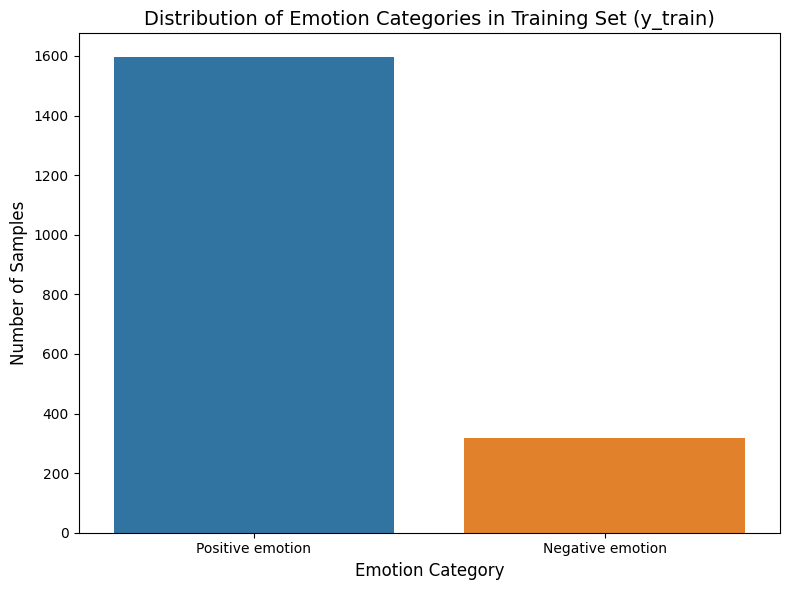

In [24]:
# visualize frequency distribution of y_train 
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_final,hue=y_train_final)
plt.title('Distribution of Emotion Categories in Training Set (y_train)', fontsize=14)
plt.xlabel('Emotion Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.tight_layout()
plt.show()

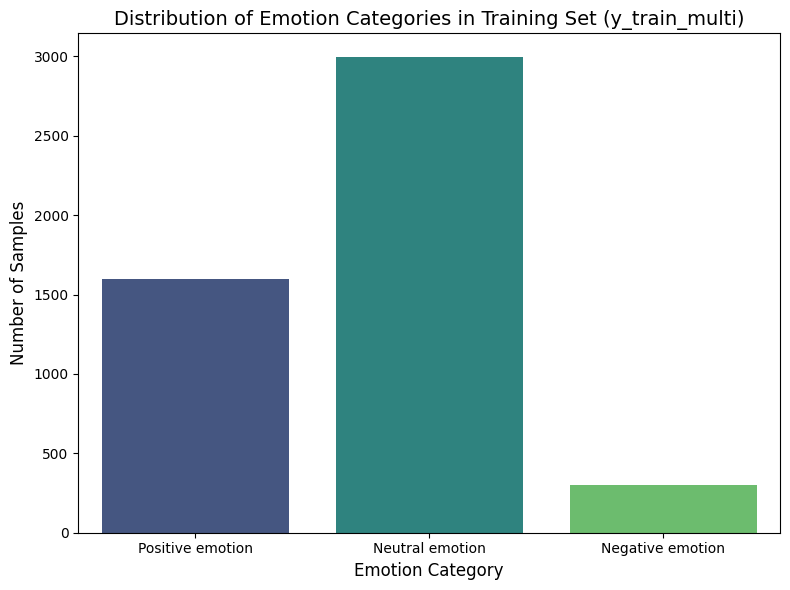

In [25]:
# visualize frequency distribution of y_train 
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_multi,hue=y_train_multi, palette='viridis')
plt.title('Distribution of Emotion Categories in Training Set (y_train_multi)', fontsize=14)
plt.xlabel('Emotion Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.tight_layout()
plt.show()

In [26]:
# function to visualize frequency distribution
def visualize_top_10(freq_dist_list, title):

    # Extract data for plotting
    top_10_items = freq_dist_list[:10]

    tokens = [item[0] for item in top_10_items]
    counts = [item[1] for item in top_10_items]


    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    

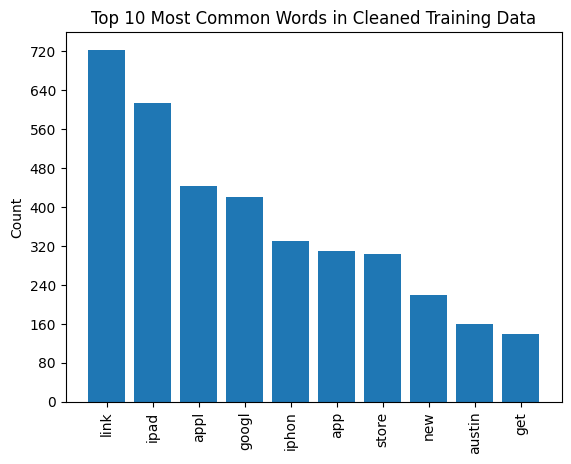

In [27]:
# 
all_words_from_cleaned_tweets = []
for tweet_str in X_train_cleaned:
    # Split each cleaned tweet string into words and add to the list
    all_words_from_cleaned_tweets.extend(tweet_str.split())

# Create a frequency distribution using Counter
cleaned_words_freq = Counter(all_words_from_cleaned_tweets)

visualize_top_10(cleaned_words_freq.most_common(10), 'Top 10 Most Common Words in Cleaned Training Data')

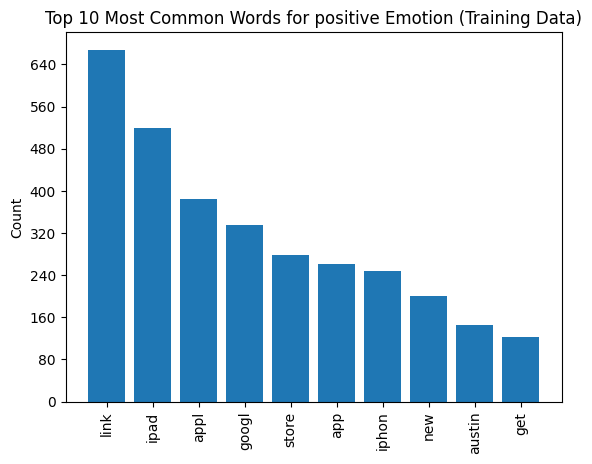

In [28]:
positive_emotion_tweets_cleaned = X_train_cleaned[y_train_final == 'Positive emotion']

all_words_positive = []
for tweet_str in positive_emotion_tweets_cleaned:
    all_words_positive.extend(tweet_str.split())

# 3. Calculate frequency distribution
freq_dist_positive = Counter(all_words_positive)

visualize_top_10( freq_dist_positive.most_common(10), 'Top 10 Most Common Words for positive Emotion (Training Data)')

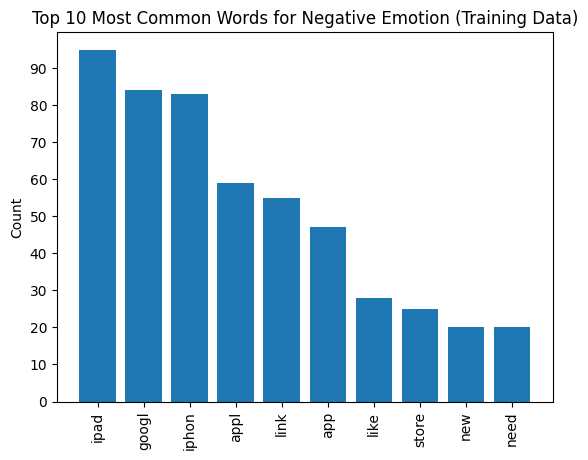

In [29]:
negative_emotion_tweets_cleaned = X_train_cleaned[y_train_final == 'Negative emotion']
all_words_negative = []
for tweet_str in negative_emotion_tweets_cleaned:
    all_words_negative.extend(tweet_str.split())

# 3. Calculate frequency distribution
freq_dist_negative = Counter(all_words_negative)

# 4. Use visualize_top_10 function
visualize_top_10( freq_dist_negative.most_common(10), 'Top 10 Most Common Words for Negative Emotion (Training Data)')

In [30]:
brands ={'iPhone': 'Apple', 'iPad or iPhone App': 'Apple', 'iPad': 'Apple', 
            'Google': 'Google', 'Unknown': 'Unknown',
            'Android': 'Google', 'Apple': 'Apple', 'Android App': 'Google',
            'Other Google product or service': 'Google',
            'Other Apple product or service': 'Apple'}
df_brand['Brand'] = df_brand['emotion_in_tweet_is_directed_at'].map(brands)
df_brand['Brand'].unique()
df_brand.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google


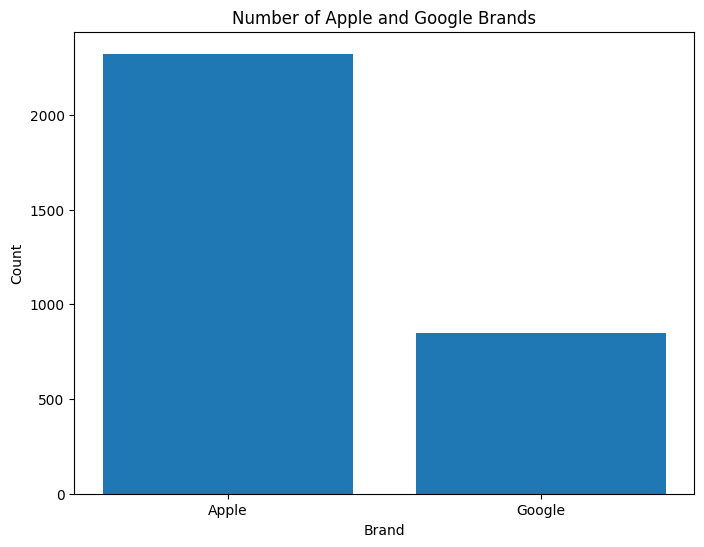

In [31]:
# Counts the number of Apple and Google brands
apple_count = df_brand[df_brand['Brand'] == 'Apple'].shape[0]
google_count = df_brand[df_brand['Brand'] == 'Google'].shape[0]

# Creates a bar graph of the brand counts
brands = ['Apple', 'Google']
counts = [apple_count, google_count]

plt.figure(figsize=(8, 6))
plt.bar(brands, counts)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Number of Apple and Google Brands')
plt.show()

In [32]:
df_brand['is_there_an_emotion_directed_at_a_brand_or_product']  = df_brand['is_there_an_emotion_directed_at_a_brand_or_product'].replace({
    'No emotion toward brand or product': 'Neutral emotion',
    'I can\'t tell': 'Neutral emotion'
})
df_brand['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Neutral emotion     5307
Positive emotion    2869
Negative emotion     545
Name: count, dtype: int64

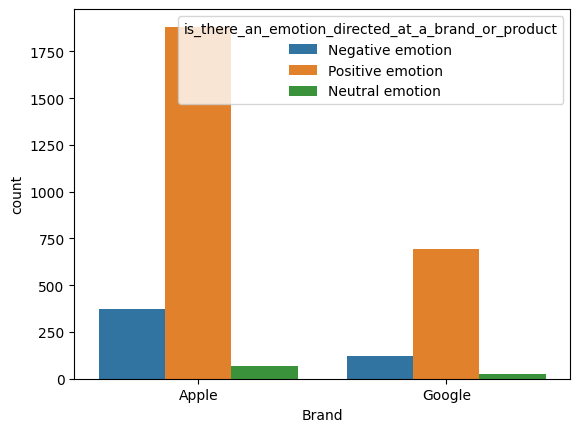

In [33]:
sns.countplot(data=df_brand, x='Brand', hue='is_there_an_emotion_directed_at_a_brand_or_product');

In [34]:
df_brand['preprocessed_text'] = df_brand['tweet_text'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

df_brand.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,Brand,preprocessed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,iphon hr tweet dead need upgrad plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,hope year' festiv crashi year' iphon app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,great stuff fri marissa mayer googl tim o'reil...


### EXAMINING USER OPINIONS ON BRANDS

In [35]:
def analyze_sentiments(data, brand, emotion, top_n):
    # Filter the dataset for the specified brand and emotion
    brand_data = df_brand[(df_brand['Brand'] == brand) & (df_brand['is_there_an_emotion_directed_at_a_brand_or_product'] == emotion)]

    processed_tokens_lists = brand_data['preprocessed_text'].fillna('').apply(lambda x: x.split()).tolist()

    # Concatenate all lists of tokens into a single flat list
    brand_tokens = [token for sublist in processed_tokens_lists for token in sublist]

    # Create a frequency distribution of tokens
    brand_freq_dist = FreqDist(brand_tokens)

    # Get the most common tokens
    top_tokens = brand_freq_dist.most_common(top_n)

    # Extract the tokens and frequencies
    tokens, frequencies = zip(*top_tokens)

    # Plot the frequency distribution
    plt.figure(figsize=(10, 6))
    plt.bar(tokens, frequencies)
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} {emotion} Tokens for {brand}')
    plt.xticks(rotation=90)
    plt.show()

### APPLE

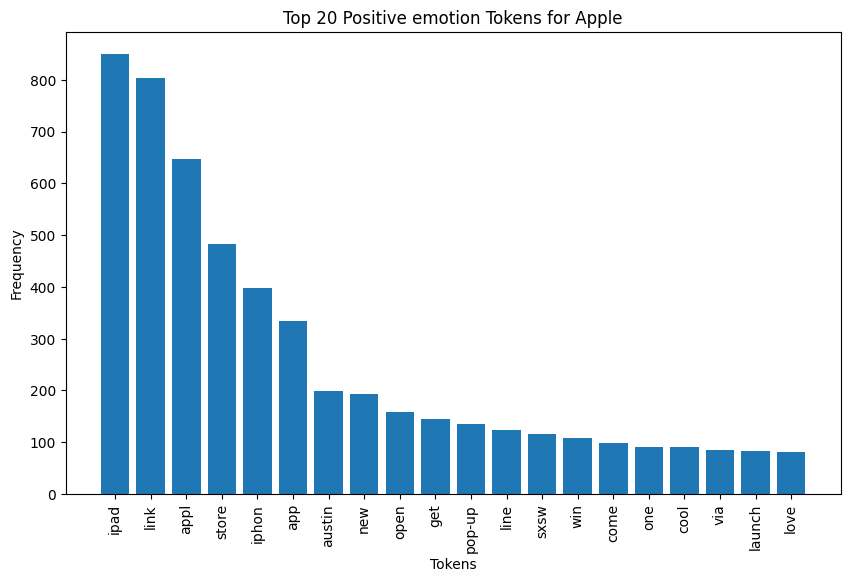

In [36]:
analyze_sentiments(df_brand, 'Apple', 'Positive emotion', 20)

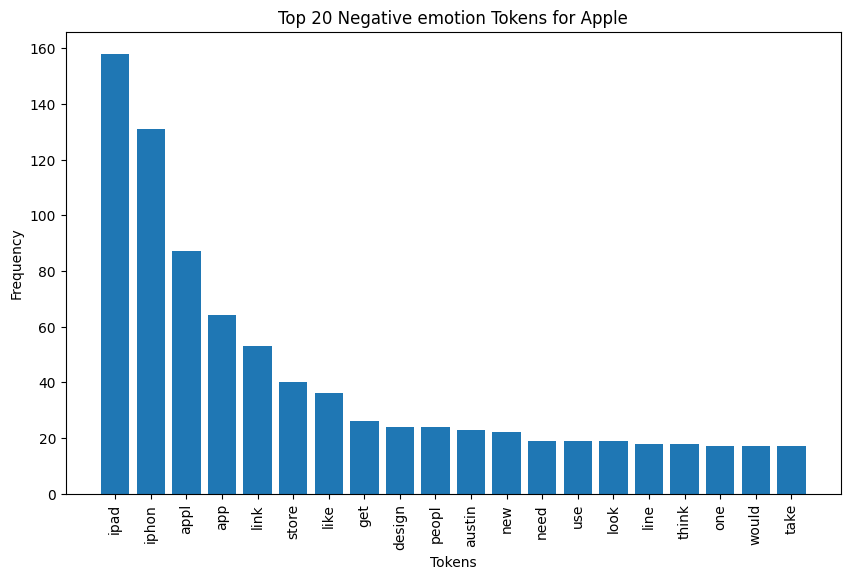

In [37]:
analyze_sentiments(df_brand, 'Apple', 'Negative emotion', 20)

* Both ipad, apple, iphone appear in both negative and positive reviews

### GOOGLE

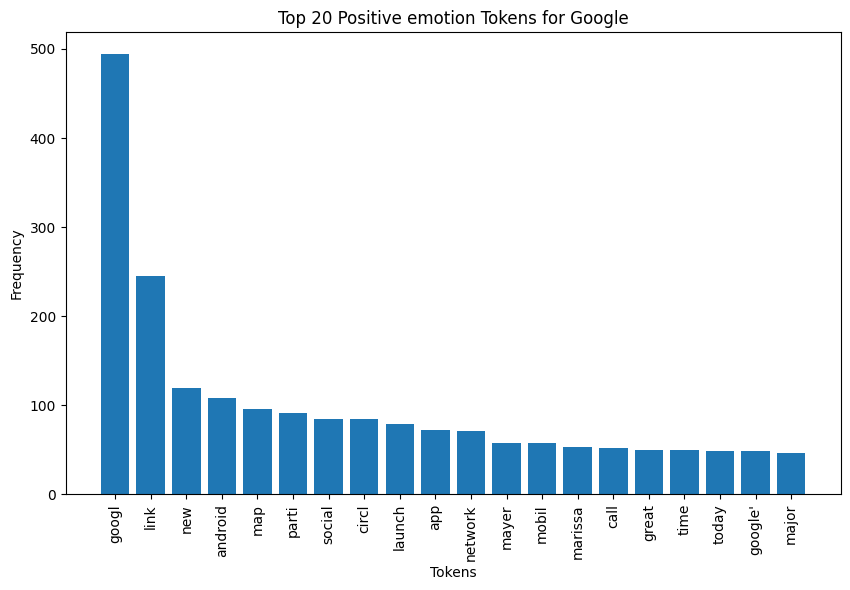

In [38]:
analyze_sentiments(df_brand, 'Google', 'Positive emotion', 20)

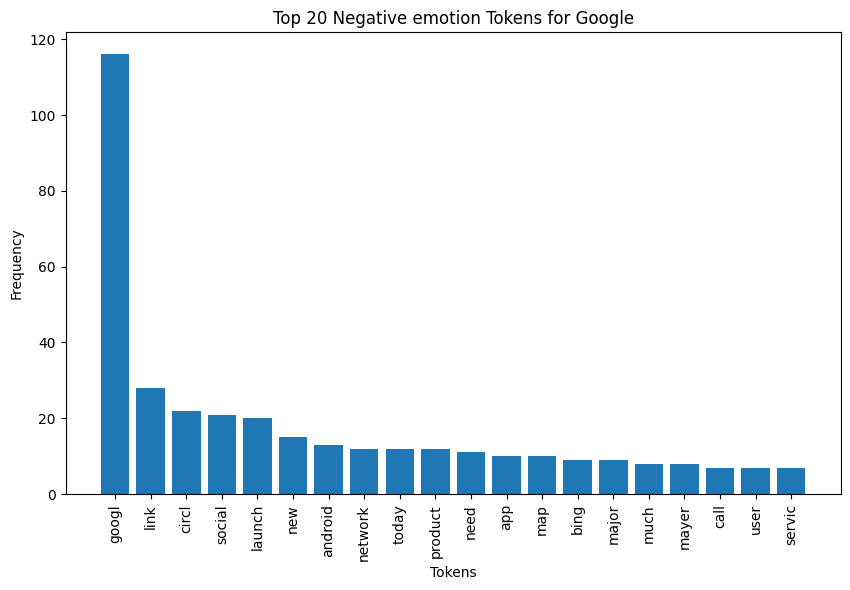

In [39]:
analyze_sentiments(df_brand, 'Google', 'Negative emotion', 20)

### FEATURE EXTRACTION
* Apply Tf-idf to get obtain words that are perceived to be important based on its appearance frequency.

In [40]:
tfidf_sample = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train_cleaned and transform it
X_train_sample = tfidf_sample.fit_transform(X_train_cleaned)

# Get the feature names from the vectorizer
feature_names = tfidf_sample.get_feature_names_out()

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_sample, columns=feature_names)


,app,appl,austin,get,googl,ipad,iphon,link,new,store
0,0,0,0.848764,0,0,0.528772,0,0,0,0
1,0,0,0,0,0,1.0,0,0,0,0
2,0,0,0,0,0,0,0,1.0,0,0
3,0,0.488055,0.673326,0,0,0,0,0,0,0.555369
4,0,0,0,0,0,0,0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...
1909,0,0,0,0,0,0,1.0,0,0,0
1910,0,0,0,0,0,0.735232,0,0.677816,0,0
1911,0,0.714923,0.493157,0,0,0,0,0.28324,0,0.406764
1912,0.646954,0,0,0,0,0,0.617945,0.446761,0,0


### **BINARY CLASSIFIERS**
#### LOGISTIC REGRESSION - BASELINE MODEL

In [41]:
# create pipeline for our baseline model 
baseline_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, min_df=1)),
    ('logreg', LogisticRegression(random_state=42, solver='liblinear'))
])

# fit on the training data
baseline_pipeline.fit(X_train_cleaned, y_train_final)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('logreg',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [42]:
# evaluate model on validation set
y_val_pred = baseline_pipeline.predict(X_val_cleaned)

print(classification_report(y_val, y_val_pred))

                  precision    recall  f1-score   support

Negative emotion       0.90      0.08      0.16       106
Positive emotion       0.85      1.00      0.92       533

        accuracy                           0.85       639
       macro avg       0.87      0.54      0.54       639
    weighted avg       0.85      0.85      0.79       639



In [43]:
y_pred_base = baseline_pipeline.predict(X_test_cleaned) 
accuracy_score(y_test, y_pred_base)

0.8615023474178404

* The model is prioritizing the majority class(Positive emotions) and as it is able to identify and recall perfectly but struggling recalling negative emotions
* The 85% accuracy is good but we have to be aware of the class imbalance which makes the accuracy misleading
* The accuracy slightly increases on the unseen data

In [44]:
# hyperparameter tuning

tuned_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')) 
])

param_grid = {
    'tfidf__max_features': [500, 1000, 1500],
    'tfidf__ngram_range': [(1, 1), (1, 2)],   
    'tfidf__min_df': [1, 2], 
    'logreg__C': [0.1, 1.0, 10.0]              
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    tuned_pipeline,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1
)

grid_search.fit(X_train_cleaned, y_train_final)

grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


{'logreg__C': 10.0,
 'tfidf__max_features': 1500,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 1)}

In [45]:
# evaluate using optimal parameters
optimal_pipeline = grid_search.best_estimator_

y_val_pred = optimal_pipeline.predict(X_val_cleaned)

print(classification_report(y_val, y_val_pred))

                  precision    recall  f1-score   support

Negative emotion       0.50      0.58      0.54       106
Positive emotion       0.91      0.88      0.90       533

        accuracy                           0.83       639
       macro avg       0.71      0.73      0.72       639
    weighted avg       0.85      0.83      0.84       639



In [46]:
y_pred_optimal= optimal_pipeline.predict(X_test_cleaned) 
accuracy_score(y_test, y_pred_optimal)

0.8427230046948356

* The accuracy has slightly reduced but the model has improved in identifying the minority class(negative emotions)
* THE accuracy is the same on the unseen data

#### 2. MULTINOMIAL NAIVE BAYES

In [47]:
#
mnb_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

param_grid = [
    {
        'vectorizer': [CountVectorizer()],
        'vectorizer__max_features': [500, 1000, 1500],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'vectorizer__min_df': [1, 2],
        'mnb__alpha': [0.1, 0.5, 1.0, 2.0]
    },
    {
        'vectorizer': [TfidfVectorizer()], 
        'vectorizer__max_features': [500, 1000, 1500],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'vectorizer__min_df': [1, 2],
        'mnb__alpha': [0.1, 0.5, 1.0, 2.0]
    }
]

# Use f1_weighted for scoring, as it's suitable for imbalanced binary datasets as well.
grid_search = GridSearchCV(
    mnb_pipeline,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1
)
# fit on training data
grid_search.fit(X_train_cleaned, y_train_final)

# optimal parameters
grid_search.best_params_


Fitting 3 folds for each of 96 candidates, totalling 288 fits


{'mnb__alpha': 0.1,
 'vectorizer': CountVectorizer(),
 'vectorizer__max_features': 1500,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1)}

In [48]:
# evaluate on validation set
optimal_pipeline = grid_search.best_estimator_
y_val_pred = optimal_pipeline.predict(X_val_cleaned)

print(classification_report(y_val, y_val_pred))

                  precision    recall  f1-score   support

Negative emotion       0.60      0.50      0.54       106
Positive emotion       0.90      0.93      0.92       533

        accuracy                           0.86       639
       macro avg       0.75      0.72      0.73       639
    weighted avg       0.85      0.86      0.86       639



In [49]:
y_pred_optimal = optimal_pipeline.predict(X_test_cleaned)
accuracy_score(y_test, y_pred_optimal)

0.8767605633802817

* While the models accuracy increased, the trade-off between precision and recall for the naegative emotions remains a challenge
* Accuracy on the unseen data increased too

In [50]:
# try and handle class imbalance
smote_pipeline = ImbPipeline([
    ('vectorizer', CountVectorizer()),
    ('smote', SMOTE(random_state=42)), 
    ('mnb', MultinomialNB())
])

param_grid = [
    {
        'vectorizer': [CountVectorizer()],
        'vectorizer__max_features': [500, 1000, 1500],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'vectorizer__min_df': [1, 2],
        'smote__k_neighbors': [3, 4, 5], 
        'mnb__alpha': [0.1, 0.5, 1.0, 2.0]
    },
    {
        'vectorizer': [TfidfVectorizer()],
        'vectorizer__max_features': [500, 1000, 1500],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'vectorizer__min_df': [1, 2],
        'smote__k_neighbors': [2, 3, 4, 5], 
        'mnb__alpha': [0.1, 0.5, 1.0, 2.0]
    }
]


grid_search = GridSearchCV(
    smote_pipeline,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1
)

# fit on training data
grid_search.fit(X_train_cleaned, y_train_final)

# optimal parameters
grid_search.best_params_

Fitting 3 folds for each of 336 candidates, totalling 1008 fits


{'mnb__alpha': 0.1,
 'smote__k_neighbors': 3,
 'vectorizer': CountVectorizer(),
 'vectorizer__max_features': 1500,
 'vectorizer__min_df': 2,
 'vectorizer__ngram_range': (1, 2)}

In [51]:
# evaluate on validation set
optimal_pipeline = grid_search.best_estimator_
y_val_pred = optimal_pipeline.predict(X_val_cleaned)

print(classification_report(y_val, y_val_pred))

                  precision    recall  f1-score   support

Negative emotion       0.50      0.51      0.50       106
Positive emotion       0.90      0.90      0.90       533

        accuracy                           0.83       639
       macro avg       0.70      0.70      0.70       639
    weighted avg       0.83      0.83      0.83       639



In [52]:
y_pred_optimal = optimal_pipeline.predict(X_test_cleaned)
accuracy_score(y_test, y_pred_optimal)

0.8345070422535211

* Slight drop in the in accuracy is expected as we prioritized the minority class 
* The precision and recall balance for the negative has improved compared to previous models even though there is a slight decrease in precision

### **MULTICLASS CLASSIFICATION**


In [53]:
# confusion matrix and roc curve function
def plot_metrics_combined(clf, X_test, y_true, class_names, fig_size=(14, 6), cmap_cm='BrBG_r'):
    n_class = len(class_names)

    # Set up the figure and subplots
    fig, ax = plt.subplots(1, 2, figsize=fig_size)

    y_pred = clf.predict(X_test) 

    y_pred = clf.predict(X_test)

    # --- Calculate and print Accuracy Score ---
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy Score: {accuracy:.4f}")

    ConfusionMatrixDisplay.from_predictions( 
        y_true=y_true,                       
        y_pred=y_pred,                      
        cmap=cmap_cm,
        normalize='true',
        ax=ax[0],
        display_labels=class_names,
        values_format=".2f"
    )
    ax[0].set_title('Normalized Confusion Matrix')
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].tick_params(axis='y', rotation=0)

    # Plot ROC Curve
    pred_prob = clf.predict_proba(X_test)
    colors = plt.cm.get_cmap('tab10', n_class)

    lb = LabelBinarizer()
    y_true_binarized = lb.fit_transform(y_true)

    # Handle cases where LabelBinarizer might return 1D array for binary classification
    if y_true_binarized.ndim == 1:
        y_true_binarized = y_true_binarized.reshape(-1, 1)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        ax[1].plot(fpr[i], tpr[i], color=colors(i), label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

      # Add diagonal line (random classifier)
    ax[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
               
    ax[1].set_title('Multiclass ROC Curve (One-vs-Rest)')
    ax[1].set_xlabel('False Positive Rate (FPR)')
    ax[1].set_ylabel('True Positive Rate (TPR)')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])

    plt.tight_layout() 
    plt.show()

### 1. SUPPORT VECTOR CLASSIFIER

In [54]:
# fixed parameters 
svc_params = {'random_state': 42, 'class_weight': 'balanced', 'C': 1.0, 'kernel': 'linear', 'probability': True}

# Pipeline for TfidfVectorizer
svc_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=2)), 
    ('svc', SVC(**svc_params))
])

# Train using the multiclass dataset
svc_pipeline.fit(X_train_clean, y_train_multi)

y_val_pred= svc_pipeline.predict(X_val_clean)
print(classification_report(y_val_multi, y_val_pred))

                  precision    recall  f1-score   support

Negative emotion       0.18      0.46      0.26        99
 Neutral emotion       0.77      0.62      0.68       999
Positive emotion       0.54      0.57      0.55       533

        accuracy                           0.59      1631
       macro avg       0.49      0.55      0.50      1631
    weighted avg       0.66      0.59      0.62      1631



* The model is struggling across the board with an overall accuracy of 58%
* The precision and recall of both positive and negative emotions are quite weak

Accuracy Score: 0.6000


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15640\3897770315.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_class)


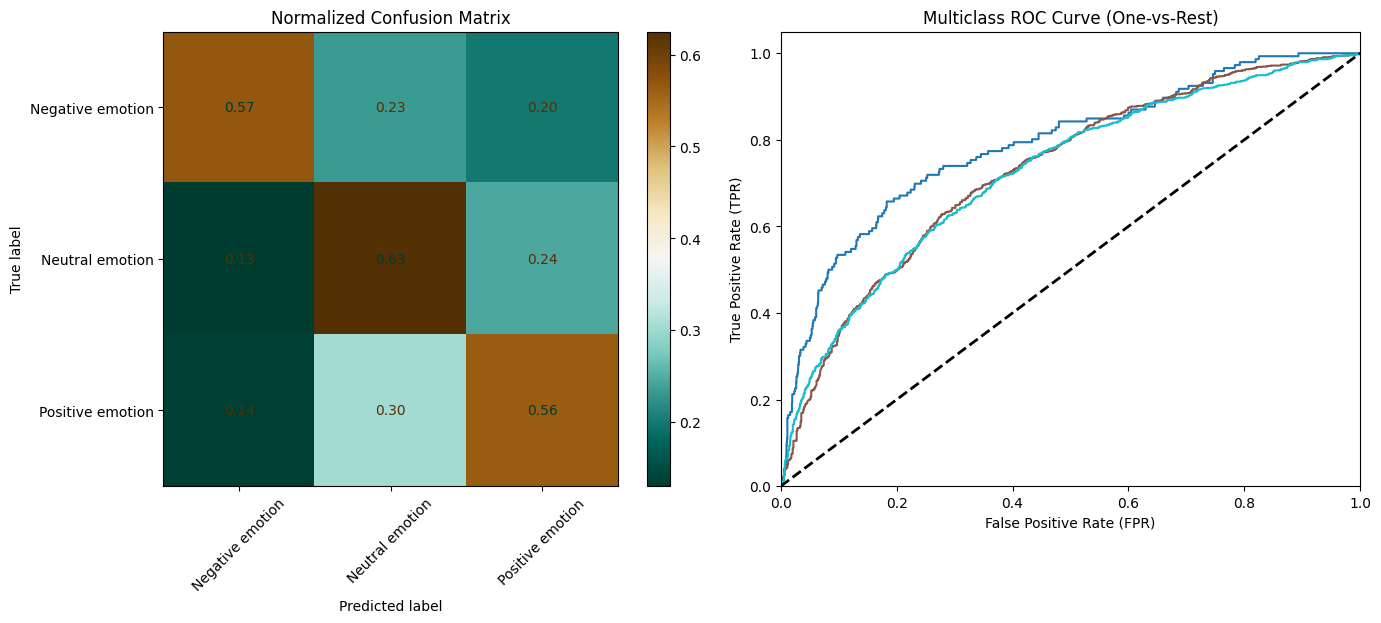

In [55]:
plot_metrics_combined(svc_pipeline, X_test_clean, y_test_multi, class_names=[ 'Negative emotion', 'Neutral emotion', 'Positive emotion'])

* This confirms that the model is biased and tends to assign either positive or neutral emotion when the emotion is negative

In [56]:
# parameters for SVC 
svc_params = {'random_state': 42, 'C': 1.0, 'kernel': 'linear', 'probability': True}

# intergrate random oversampling
ros_pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=2)), 
    ('random_oversampler', RandomOverSampler(random_state=42)), 
    ('svc', SVC(**svc_params))
])

# Train the pipeline
ros_pipeline.fit(X_train_clean, y_train_multi)

y_val_pred= ros_pipeline.predict(X_val_clean)
print(classification_report(y_val_multi, y_val_pred))

                  precision    recall  f1-score   support

Negative emotion       0.17      0.40      0.24        99
 Neutral emotion       0.75      0.62      0.68       999
Positive emotion       0.52      0.56      0.54       533

        accuracy                           0.58      1631
       macro avg       0.48      0.53      0.48      1631
    weighted avg       0.64      0.58      0.60      1631



* The model still struggles to classify tweets across all categories

Accuracy Score: 0.5917


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15640\3897770315.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_class)


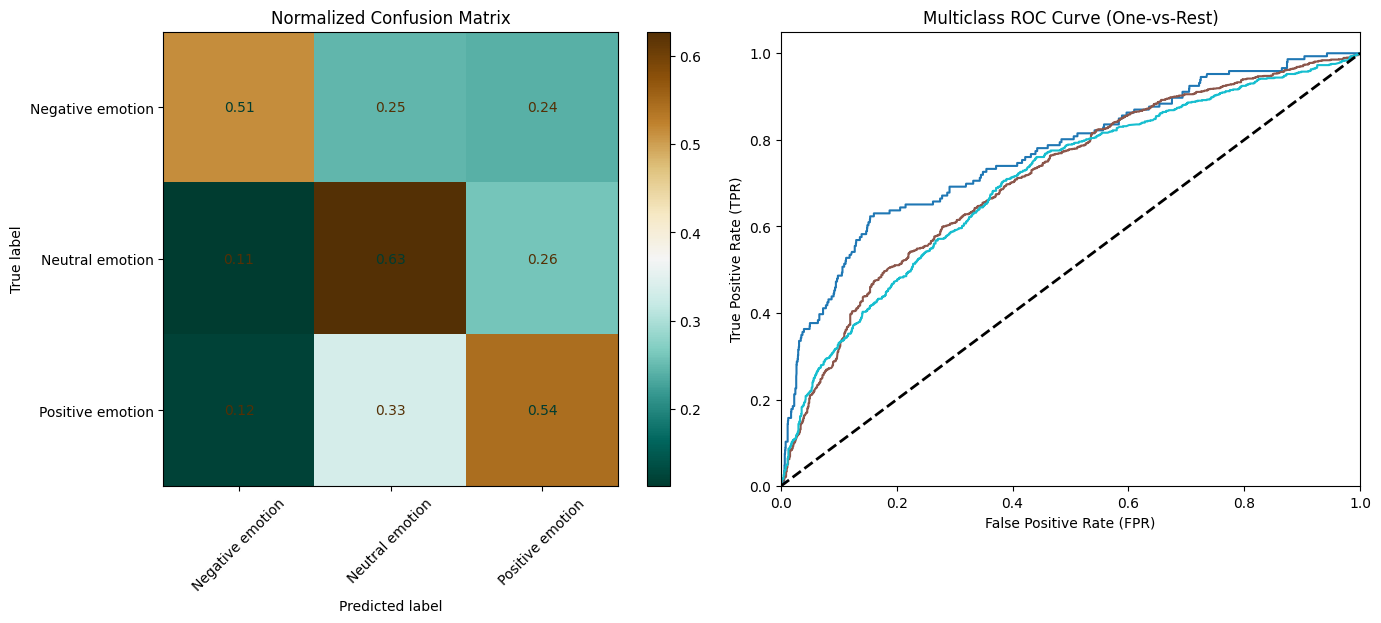

In [57]:
plot_metrics_combined(ros_pipeline, X_test_clean, y_test_multi, class_names=[ 'Negative emotion', 'Neutral emotion', 'Positive emotion'])

* No significant changes the negative recall and accuracy slightly increased on the unseen data


### K-NEAREST NEIGHBORS CLASSIFIER

In [58]:
# knn parameters
knn_params = {'n_neighbors': 3, 'weights': 'distance'} 


# Pipeline for TfidfVectorizer and KNeighborsClassifier
knn_pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=2)),
    ('knn', KNeighborsClassifier(**knn_params))
])

# Train the pipeline
knn_pipeline.fit(X_train_clean, y_train_multi)

y_val_pred= knn_pipeline.predict(X_val_clean)
print(classification_report(y_val_multi, y_val_pred))

                  precision    recall  f1-score   support

Negative emotion       0.22      0.14      0.17        99
 Neutral emotion       0.73      0.64      0.68       999
Positive emotion       0.45      0.58      0.51       533

        accuracy                           0.59      1631
       macro avg       0.47      0.46      0.46      1631
    weighted avg       0.61      0.59      0.60      1631



In [59]:
knn_params = {'n_neighbors': 2, 'weights': 'uniform'} 


# Pipeline for TfidfVectorizer and KNeighborsClassifier
knn_ros_pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=2)),
     ('random_oversampler', RandomOverSampler(random_state=42)), 
    ('knn', KNeighborsClassifier(**knn_params))
])

# Train the pipeline
knn_ros_pipeline.fit(X_train_clean, y_train_multi)

y_val_pred= knn_ros_pipeline.predict(X_val_clean)
print(classification_report(y_val_multi, y_val_pred))

                  precision    recall  f1-score   support

Negative emotion       0.19      0.19      0.19        99
 Neutral emotion       0.65      0.83      0.73       999
Positive emotion       0.53      0.25      0.34       533

        accuracy                           0.60      1631
       macro avg       0.45      0.42      0.42      1631
    weighted avg       0.58      0.60      0.57      1631



* The model is struggling to define clear boundaries between the sentiment categories even after parameter adjustments


Accuracy Score: 0.6166


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15640\3897770315.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_class)


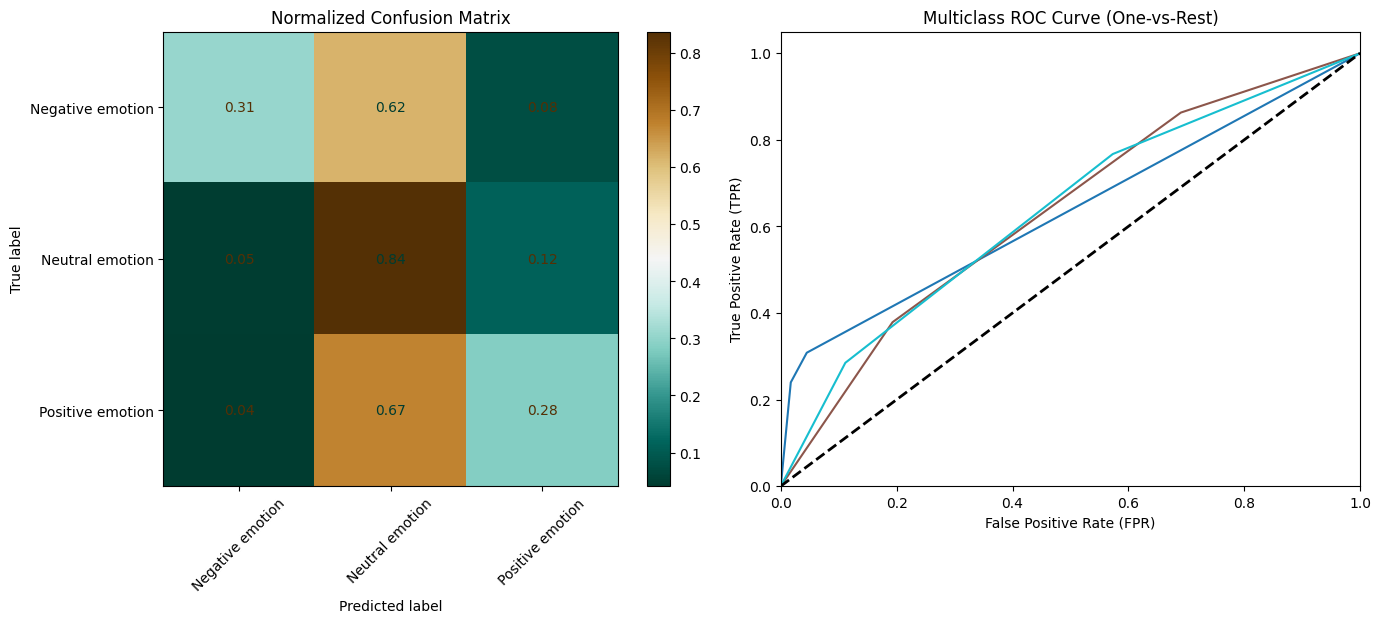

In [60]:
plot_metrics_combined(knn_ros_pipeline, X_test_clean, y_test_multi, class_names=[ 'Negative emotion', 'Neutral emotion', 'Positive emotion'])

* The recall of all has increased and the accuracy on unseen data

### MULTI-LAYER PERCEPTRON CLASSIFIER
* Since our multi_class models are all struggling, We will model a basic neural network to try and capture our datasets complexities

In [61]:
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=2)
scaler = StandardScaler(with_mean=False) 


# Transform training data
X_train_vectorized = vectorizer.fit_transform(X_train_clean)
X_train_scaled = scaler.fit_transform(X_train_vectorized)
X_train_dense = X_train_scaled.toarray().astype(np.float32) 

# Transform validation data
X_val_vectorized = vectorizer.transform(X_val_clean)
X_val_scaled = scaler.transform(X_val_vectorized)
X_val_dense = X_val_scaled.toarray().astype(np.float32) 

# Transform test data
X_test_vectorized = vectorizer.transform(X_test_clean)
X_test_scaled = scaler.transform(X_test_vectorized)
X_test_dense = X_test_scaled.toarray().astype(np.float32) 

In [62]:
# label encode the multiclass y
le = LabelEncoder()
y_multi_encoded = le.fit_transform(y_multi) 
X_train_multi, X_test_multi, y_train_multi_encoded, y_test_multi_encoded = train_test_split(X_multi, y_multi_encoded, test_size=0.25, random_state=42, stratify=y_multi_encoded)
X_train_multi, X_val_multi, y_train_multi_encoded, y_val_multi_encoded = train_test_split(X_train_multi, y_train_multi_encoded, test_size=0.25, random_state=42, stratify=y_train_multi_encoded)


In [63]:
mlp_params = {
    'hidden_layer_sizes': (100,), 
    'activation': 'relu',        
    'solver': 'adam',            
    'max_iter': 500,             
    'random_state': 42,
    'early_stopping': True,      
    'validation_fraction': 0.1   
}

# Initialize MLPClassifier
mlp_model = MLPClassifier(**mlp_params)

mlp_model.fit(X_train_dense, y_train_multi_encoded)

# Predict using the dense, scaled validation data
y_val_pred_mlp_encoded = mlp_model.predict(X_val_dense)


# Decode predictions back to original labels for classification report
y_val_pred_mlp = le.inverse_transform(y_val_pred_mlp_encoded)

# Use the original (decoded) validation labels for the report
print(classification_report(y_val_multi, y_val_pred_mlp))

                  precision    recall  f1-score   support

Negative emotion       0.07      0.03      0.04        99
 Neutral emotion       0.61      0.67      0.64       999
Positive emotion       0.35      0.32      0.34       533

        accuracy                           0.52      1631
       macro avg       0.34      0.34      0.34      1631
    weighted avg       0.49      0.52      0.51      1631



In [64]:
y_pred_mlp = mlp_model.predict(X_test_dense)

accuracy_score(y_test_multi_encoded, y_pred_mlp)

0.504367816091954

* The overall proportion of correctly predicted tweets is 54%. 
* This is the lowest accuracy observed so far on both the validation and test set across all models you've tested, indicating the MLP with current settings is struggling significantly.

In [65]:
base_mlp_params = {
    'activation': 'relu',        
    'solver': 'adam',            
    'max_iter': 500,             
    'random_state': 42,
    'early_stopping': True,      
    'validation_fraction': 0.1   
}

# hyperparameter tuning with gridsearchcv
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (40, 30)], 
    'alpha': [0.0001, 0.001, 0.01],                  
}

# Instantiate MLPClassifier
mlp_base = MLPClassifier(**base_mlp_params)

# Initialize GridSearchCV.
grid_search_mlp = GridSearchCV(
    mlp_base,
    param_grid,
    cv=3,                     
    scoring='f1_weighted',
    verbose=1
)

# Fit GridSearchCV on the dense, scaled training data
grid_search_mlp.fit(X_train_dense, y_train_multi_encoded)


grid_search_mlp.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'alpha': 0.001, 'hidden_layer_sizes': (100,)}

In [66]:
best_mlp_model = grid_search_mlp.best_estimator_

# Predict using the dense, scaled validation data with the best model
y_val_pred_mlp_encoded = best_mlp_model.predict(X_val_dense)

# Decode predictions back to original labels for classification report
y_val_pred_mlp = le.inverse_transform(y_val_pred_mlp_encoded)

print(classification_report(y_val_multi, y_val_pred_mlp))

                  precision    recall  f1-score   support

Negative emotion       0.06      0.02      0.03        99
 Neutral emotion       0.61      0.70      0.65       999
Positive emotion       0.33      0.28      0.30       533

        accuracy                           0.52      1631
       macro avg       0.34      0.33      0.33      1631
    weighted avg       0.48      0.52      0.50      1631



In [67]:
y_pred_mlp = best_mlp_model.predict(X_test_dense)

accuracy_score(y_test_multi_encoded, y_pred_mlp)

0.519080459770115

### EVALUATION
* Binary classifiers had better accuracy scores even though they had a harder time predicting negative emotions due to class imbalance.
 Oversampling methods were used to try balance the precision and recall of negative emotion and Logistic regression had the best model with an accuracy of 83% on validation set and 84% on the test set with negative emotions having a precision of 0.5 and recall of 0.58

* Multiclass classifiers struggled to find a balance, since the majority of the emotions were neutral and this class imbalance made it difficult for the models to accurately distinguish between positive, negative, and neutral sentiments without bias towards the over-represented neutral class.


### **RECOMMENDATIONS**
* Implement a social media strategy for continuous sentiment monitoring to ensure ongoing informed decision-making.

* Utilize analyzed sentiment data to directly inform and enhance the quality of products and services

* Broaden the analysis to include industry competitors to gain insights into customer perceptions and identify opportunities for unique positioning

### **CONCLUSION**
The project successfully aimed to develop a text classifier to accurately distinguish between positive, neutral, and negative sentiments, including identifying the reasons for such classifications. It also sought to compare sentiment towards Apple and Google products for competitive analysis and provide insights for increasing customer satisfaction.
The models developed in this project equip companies such as Apple and Google with the means to effectively track sentiment related to their events and products across social media. This allows businesses to remain aware of public sentiment regarding their competitors, potentially offering a competitive advantage. However, a key limitation of the analysis stems from the crowd-sourced dataset, particularly the inherent subjectivity of how the tweets were classified and a significant amount of missing data from one of the features.
 